In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.stats import chi2_contingency
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter
import pickle

# Load the dataset
data = np.load('dff_data_rf.npz', allow_pickle=True)
spike_data = np.load('OASIS_spikes.npz', allow_pickle=True)

t = data['t']                    # (105968,)
dff = data['dff']                # (189, 105968)
stim_table = pd.DataFrame(data['stim_table'])  # (8880, 3)
stim_table.columns = ['frame', 'start', 'end']
stim = data['stim']             # (9000, 16, 28)
roi_masks = data['roi_masks']   # (189, 512, 512)
max_projection = data['max_projection']  # (512, 512)
running_speed = data['running_speed']    # (2, 105968)
stim_epoch_table = pd.DataFrame(data['stim_epoch_table'])  # (7, 3)
spike_traces = spike_data['spike_likelihoods']

# Basic checks
summary = {
    "t_shape": t.shape,
    "dff_shape": dff.shape,
    "stim_table_shape": stim_table.shape,
    "stim_shape": stim.shape,
    "roi_masks_shape": roi_masks.shape,
    "max_projection_shape": max_projection.shape,
    "running_speed_shape": running_speed.shape,
    "stim_epoch_table_shape": stim_epoch_table.shape,
    "spike_traces_shape": spike_traces.shape
}

summary

{'t_shape': (105968,),
 'dff_shape': (189, 105968),
 'stim_table_shape': (8880, 3),
 'stim_shape': (9000, 16, 28),
 'roi_masks_shape': (189, 512, 512),
 'max_projection_shape': (512, 512),
 'running_speed_shape': (2, 105968),
 'stim_epoch_table_shape': (7, 3),
 'spike_traces_shape': (189, 105968)}

In [ ]:
import numpy as np
import pandas as pd

# Select a cell of interest by index (choose one with a clear receptive field)
cell_index = 114  # example cell index with many events

# Initialize event vector for each stimulus trial
event_vector = np.zeros(len(stim_table), dtype=bool)

# Use provided deconvolved spike events if available; otherwise detect events from dF/F trace
if 'events' in data:
    events_trace = data['events']  # deconvolved events array (cells x time) if provided
    # Mark trials where any event occurred during that trial's window
    for i, (start_idx, end_idx) in enumerate(stim_table[['start','end']].itertuples(index=False)):
        if np.any(events_trace[cell_index, int(start_idx):int(end_idx)+1] > 0):
            event_vector[i] = True
    event_trace_available = True
else:
    event_trace_available = False
    trace = dff[cell_index]  # dF/F trace for the cell
    # Smooth the trace with a moving average to reduce noise
    window = 5
    kernel = np.ones(window) / window
    smooth_trace = np.convolve(trace, kernel, mode='same')

    # Parameters for event detection window (frames relative to stimulus onset)
    k_min, k_max, delta = 0, 10, 3
    xx_list, yy_list = [], []
    var_dict = {}
    # Loop over each stimulus presentation (trial) to extract features
    for i, (start_idx, end_idx) in enumerate(stim_table[['start','end']].itertuples(index=False)):
        # If this trial starts immediately after previous trial ended, skip one frame to avoid overlap
        offset = 1 if i > 0 and stim_table.iloc[i].start == stim_table.iloc[i-1].end else 0
        # Define analysis window: frames [start+1+offset : start+10+offset]
        beg = int(start_idx + 1 + offset)
        endw = int(start_idx + k_max + 1 + offset)
        if endw > len(smooth_trace):  # skip if window exceeds trace length
            continue
        segment = smooth_trace[beg:endw]  # 10-frame segment after stimulus onset
        if len(segment) < k_max:
            continue
        # Compute relative fluorescence change within this window
        segment = segment - segment[0]            # subtract baseline at window start
        xx = segment[delta] - segment[0]          # early change (after 3 frames)
        yy = max(segment[delta+2] - segment[2],   # later peak change (max of frames delta+2 to delta+4 vs baseline)
                 segment[delta+3] - segment[3],
                 segment[delta+4] - segment[4])
        t0_val = segment[0]
        tf_val = segment[-1]
        xx_list.append(xx); yy_list.append(yy)
        var_dict[i] = (t0_val, tf_val, xx, yy)
    # Compute robust center (median) and spread of feature space (xx vs yy)
    xx_arr = np.array(xx_list); yy_arr = np.array(yy_list)
    mu_x = np.median(xx_arr) if len(xx_arr) > 0 else 0.0
    mu_y = np.median(yy_arr) if len(yy_arr) > 0 else 0.0
    xx_cent = xx_arr - mu_x; yy_cent = yy_arr - mu_y
    std_x = np.percentile(np.abs(xx_cent), 68.27) if len(xx_arr) > 0 else 1e-6  # robust std (1σ)
    std_y = np.percentile(np.abs(yy_cent), 68.27) if len(yy_arr) > 0 else 1e-6
    std_x = std_x if std_x > 0 else 1e-6
    std_y = std_y if std_y > 0 else 1e-6
    # Identify "noise cluster" of trials (within 4σ in feature space)
    dist = np.sqrt((xx_cent/std_x)**2 + (yy_cent/std_y)**2)
    noise_mask = dist < 4
    # Compute noise covariance for Mahalanobis distance
    if np.any(noise_mask):
        Cov = np.cov(xx_cent[noise_mask], yy_cent[noise_mask])
    else:
        Cov = np.eye(2)
    # Invert covariance matrix (robustly handle singular)
    try:
        cov_inv = np.linalg.inv(np.linalg.cholesky(Cov))
    except np.linalg.LinAlgError:
        cov_inv = np.eye(2)
    # Determine noise threshold in original feature space (4σ away from center on either axis)
    noise_threshold = max(4*std_x + mu_x, 4*std_y + mu_y)
    # Classify each trial as event or non-event based on multiple criteria
    for i, (t0_val, tf_val, xx, yy) in var_dict.items():
        # Transform (xx, yy) into noise-whitened space
        xi_z, yi_z = cov_inv.dot(np.array([xx - mu_x, yy - mu_y]))
        # Mark as an event if:
        # 1) Feature point is >4σ from noise cluster center,
        # 2) There is a sufficient fluorescence rise (yy > 0.05),
        # 3) The later change (yy) exceeds early change (xx) indicating an upward transient,
        # 4) The end-of-window value is above half the noise threshold (signal doesn't return to baseline immediately).
        if np.sqrt(xi_z**2 + yi_z**2) > 4 and yy > 0.05 and xx < yy and tf_val > noise_threshold/2:
            event_vector[i] = True

print(f"Cell {cell_index} events detected: {event_vector.sum()} out of {len(event_vector)} trials")

Cell 114 events detected: 367 out of 8880 trials


In [15]:
# Build stimulus sequence and design matrices for analysis
stim_frames = stim_table['frame'].values.astype(int)        # indices of stimulus frames presented
stim_sequence = stim[stim_frames]                           # stimulus images for each trial (shape: trials x 16 x 28)
on_mask = (stim_sequence > 127)   # True where pixel was white (ON stimulus) on each trial
off_mask = (stim_sequence < 127)  # True where pixel was black (OFF stimulus) on each trial

num_trials = len(stim_table)
num_pixels = on_mask.shape[1] * on_mask.shape[2]  # e.g., 16*28 = 448 pixel positions
# Flatten spatial dimensions for matrix operations (trials x pixels)
flat_on = on_mask.reshape(num_trials, num_pixels).astype(float)
flat_off = off_mask.reshape(num_trials, num_pixels).astype(float)

# Compute response-triggered stimulus (RTS) field: count of events when each pixel was stimulated
event_vector_float = event_vector.astype(float)  # convert boolean events to 0/1
# Sum of events for each pixel when ON or OFF (dot product between trials and event occurrences)
rts_on_flat = event_vector_float @ flat_on   # array of length num_pixels
rts_off_flat = event_vector_float @ flat_off
# Reshape back to spatial map (same shape as stimulus frames, e.g., 16x28)
rts_on = rts_on_flat.reshape(stim_sequence.shape[1], stim_sequence.shape[2])
rts_off = rts_off_flat.reshape(stim_sequence.shape[1], stim_sequence.shape[2])
print("RTS on-field shape:", rts_on.shape, " RTS off-field shape:", rts_off.shape)

RTS on-field shape: (16, 28)  RTS off-field shape: (16, 28)


In [16]:
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter
from skimage.measure import block_reduce

def blur_field(img, sigma=4):
    """Blur an image via upsampling, Gaussian filtering, and downsampling, preserving total intensity."""
    if img.sum() == 0:
        return img
    H, W = img.shape
    padded = np.zeros((3 * H, 3 * W))
    padded[H:2*H, W:2*W] = img

    # Upsampling factor (same as Allen SDK)
    upsample = 4 if H == 16 else 8
    offset = -(1 - (0.625 if upsample == 4 else 0.5625))

    # Define interpolator
    y = np.arange(padded.shape[0])
    x = np.arange(padded.shape[1])
    interp_func = RegularGridInterpolator((y, x), padded, method='linear', bounds_error=False, fill_value=0)

    # Create upsampled grid
    yy = offset + np.arange(0, padded.shape[0], 1.0 / upsample)
    xx = offset + np.arange(0, padded.shape[1], 1.0 / upsample)
    grid_y, grid_x = np.meshgrid(yy, xx, indexing='ij')
    points = np.stack([grid_y.ravel(), grid_x.ravel()], axis=-1)
    upsampled = interp_func(points).reshape(grid_y.shape)

    # Apply Gaussian blur
    filtered = gaussian_filter(upsampled, sigma=sigma, mode='constant')

    # Downsample by summing blocks
    reduced = block_reduce(filtered, (upsample, upsample), func=np.sum)

    # Normalize energy
    reduced *= img.sum() / (reduced.sum() + 1e-10)

    # Crop back to original size
    result = reduced[H:2*H, W:2*W]
    return result


# Compute blurred RTS fields for ON and OFF subfields
rts_on_blur = blur_field(rts_on, sigma=4)
rts_off_blur = blur_field(rts_off, sigma=4)

# Monte Carlo shuffle to compute per-pixel p-values (probability of response by chance)
num_shuffles = 10000
number_of_events = int(event_vector.sum())
# Concatenate ON and OFF design matrices (shape: 2*num_pixels x num_trials)
A = np.vstack([flat_on.T, flat_off.T])  # first num_pixels rows for ON, next num_pixels for OFF
actual_fraction = (A @ event_vector_float) / (number_of_events if number_of_events > 0 else 1)
p_values = np.ones(A.shape[0])  # initialize count of extreme shuffles (start at 1 for continuity)
if number_of_events > 0:
    rng = np.arange(num_trials)
    for i in range(num_shuffles):
        # Randomly select a subset of trials as "events" under the null hypothesis
        size = int(number_of_events + np.round(0.1 * number_of_events * np.random.randn()))
        size = max(0, min(num_trials, size))
        event_indices = np.random.choice(rng, size=size, replace=False)
        b = np.zeros(num_trials, dtype=float); b[event_indices] = 1.0
        frac = (A @ b) / (size if size > 0 else 1)
        # Count if shuffle fraction is less than actual fraction (for one-tailed p-value)
        p_values += (frac < actual_fraction)
# Compute p-value as 1 - CDF (proportion of shuffles with fraction less than actual)
p_values = 1 - p_values / float(num_shuffles)

# Separate ON and OFF p-value maps
pvalues_on = p_values[:num_pixels].reshape(stim_sequence.shape[1], stim_sequence.shape[2])
pvalues_off = p_values[num_pixels:].reshape(stim_sequence.shape[1], stim_sequence.shape[2])

# Apply False Discovery Rate (FDR) correction (Benjamini-Hochberg) to p-values
from statsmodels.stats.multitest import multipletests
alpha = 0.5  # using alpha=0.5 as in Allen SDK example for a lenient threshold
mask, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
fdr_mask_on = mask[:num_pixels].reshape(stim_sequence.shape[1], stim_sequence.shape[2])
fdr_mask_off = mask[num_pixels:].reshape(stim_sequence.shape[1], stim_sequence.shape[2])
print(f"FDR corrected (alpha={alpha}). Significant ON pixels: {fdr_mask_on.sum()}, OFF pixels: {fdr_mask_off.sum()}")

# Identify connected regions (contiguous significant pixels = receptive field subunits)
from scipy.ndimage import label
structure = np.ones((3, 3), dtype=int)  # 8-connected neighborhood
labeled_on, num_on = label(fdr_mask_on, structure=structure)
labeled_off, num_off = label(fdr_mask_off, structure=structure)
components_on = [(labeled_on == k) for k in range(1, num_on+1)]  # list of boolean masks for each ON subunit
components_off = [(labeled_off == k) for k in range(1, num_off+1)]  # list of masks for each OFF subunit

# Fit a 2D Gaussian to each subunit to characterize receptive field centers and spreads
def fit_gaussian(field, mask):
    """Fit a Gaussian to the field values within the given mask (returns a Gaussian image)."""
    if mask.sum() == 0:
        return np.zeros_like(field)
    Y, X = np.indices(field.shape)
    weights = field * mask  # weight by the field values in the subregion
    total = weights.sum()
    # Centroid (mean position)
    cy = (Y * weights).sum() / total
    cx = (X * weights).sum() / total
    # Variance (spread) in each dimension
    var_y = (weights * (Y - cy)**2).sum() / total
    var_x = (weights * (X - cx)**2).sum() / total
    sigma_y = np.sqrt(var_y); sigma_x = np.sqrt(var_x)
    # Amplitude = max response in the subregion
    amp = weights.max()
    # Generate Gaussian fit image
    gauss = amp * np.exp(-(((X - cx)**2) / (2*sigma_x**2 + 1e-9) + 
                            ((Y - cy)**2) / (2*sigma_y**2 + 1e-9)))
    return gauss

# Compute Gaussian fits for each ON and OFF subunit, then sum if multiple
gaussian_fits_on = [fit_gaussian(rts_on_blur, mask) for mask in components_on]
gaussian_fits_off = [fit_gaussian(rts_off_blur, mask) for mask in components_off]
gaussian_fit_on = np.sum(gaussian_fits_on, axis=0) if gaussian_fits_on else np.zeros_like(rts_on)
gaussian_fit_off = np.sum(gaussian_fits_off, axis=0) if gaussian_fits_off else np.zeros_like(rts_off)

FDR corrected (alpha=0.5). Significant ON pixels: 9, OFF pixels: 21


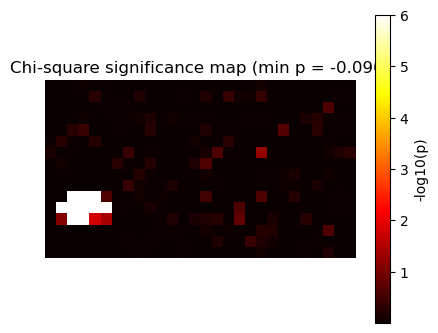

In [17]:
import matplotlib.pyplot as plt

# Combine ON/OFF corrected p-values: use the more significant (min) at each pixel location
pvals_on_map = pvals_corrected[:num_pixels].reshape(rts_on.shape)
pvals_off_map = pvals_corrected[num_pixels:].reshape(rts_off.shape)
combined_min_p = np.minimum(pvals_on_map, pvals_off_map)
# Compute -log10 p for visualization (cap minimum to avoid infinity)
chi_map = -np.log10(np.clip(combined_min_p, 1e-6, 1.0))
min_p = combined_min_p.min()

plt.figure(figsize=(5, 4))
plt.imshow(chi_map, cmap='hot')
plt.colorbar(label='-log10(p)')
plt.title(f"Chi-square significance map (min p = {min_p:.3f})")
plt.axis('off')
plt.show()

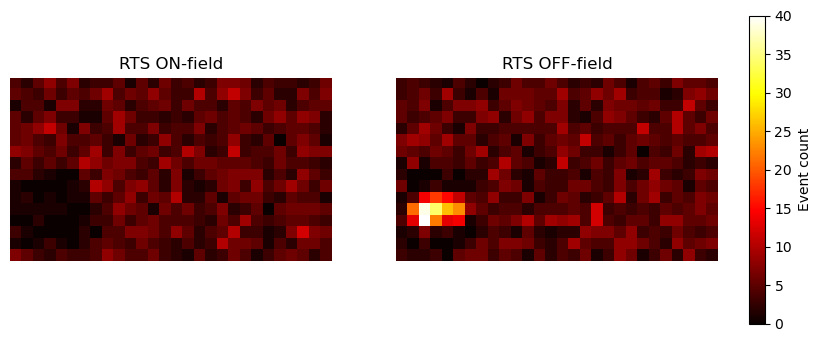

In [18]:
# Plot the RTS fields for ON and OFF subfields side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Use a "hot" colormap where higher values are brighter
vmax = max(rts_on.max(), rts_off.max())  # for consistent color scaling
im1 = ax1.imshow(rts_on, cmap='hot', vmin=0, vmax=vmax)
ax1.set_title('RTS ON-field')
ax1.axis('off')
im2 = ax2.imshow(rts_off, cmap='hot', vmin=0, vmax=vmax)
ax2.set_title('RTS OFF-field')
ax2.axis('off')
fig.colorbar(im1, ax=[ax1, ax2], fraction=0.046, pad=0.04, label='Event count')
plt.show()

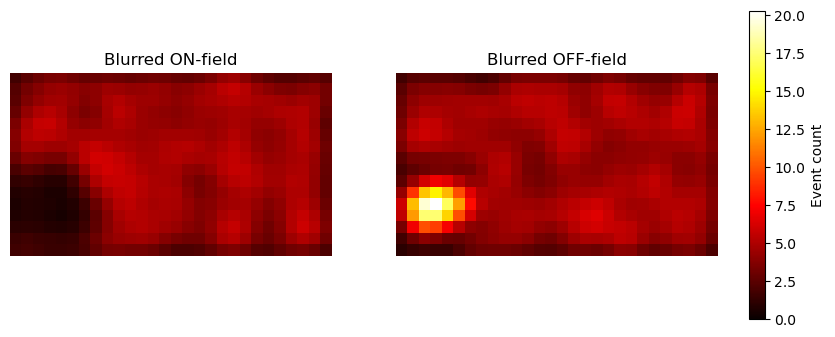

In [19]:
# Plot the blurred RTS fields for ON and OFF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
vmax_blur = max(rts_on_blur.max(), rts_off_blur.max())
im1 = ax1.imshow(rts_on_blur, cmap='hot', vmin=0, vmax=vmax_blur)
ax1.set_title('Blurred ON-field')
ax1.axis('off')
im2 = ax2.imshow(rts_off_blur, cmap='hot', vmin=0, vmax=vmax_blur)
ax2.set_title('Blurred OFF-field')
ax2.axis('off')
fig.colorbar(im1, ax=[ax1, ax2], fraction=0.046, pad=0.04, label='Event count')
plt.show()

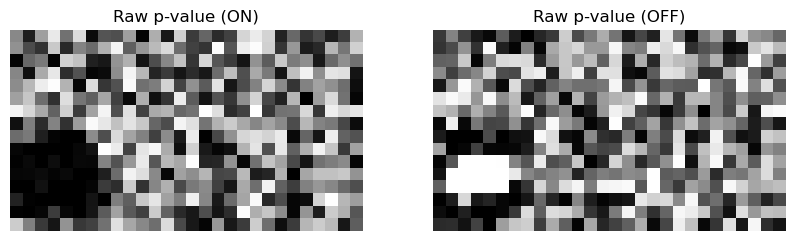

In [20]:
# Plot raw p-value maps for ON and OFF subfields (darker = more significant)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Use a reversed grayscale colormap: low p (high significance) = black, high p = white
ax1.imshow(pvalues_on, cmap='gray_r', vmin=0, vmax=1)
ax1.set_title('Raw p-value (ON)')
ax1.axis('off')
ax2.imshow(pvalues_off, cmap='gray_r', vmin=0, vmax=1)
ax2.set_title('Raw p-value (OFF)')
ax2.axis('off')
plt.show()

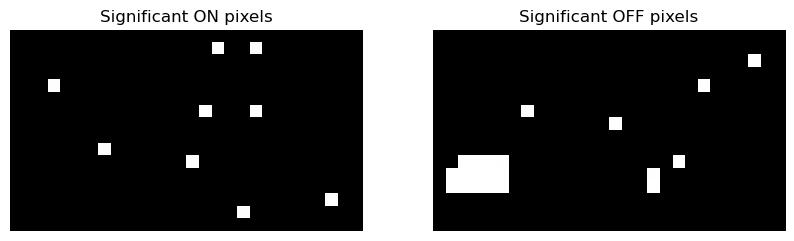

In [21]:
# Plot binary mask of significant pixels for ON and OFF (mask colored by p-value within region)
mask_on_vals = pvalues_on.copy()
mask_on_vals[~fdr_mask_on] = 1.0  # set non-significant to 1 (white in gray_r)
mask_off_vals = pvalues_off.copy()
mask_off_vals[~fdr_mask_off] = 1.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(mask_on_vals, cmap='gray_r', vmin=0, vmax=1)
ax1.set_title('Significant ON pixels')
ax1.axis('off')
ax2.imshow(mask_off_vals, cmap='gray_r', vmin=0, vmax=1)
ax2.set_title('Significant OFF pixels')
ax2.axis('off')
plt.show()

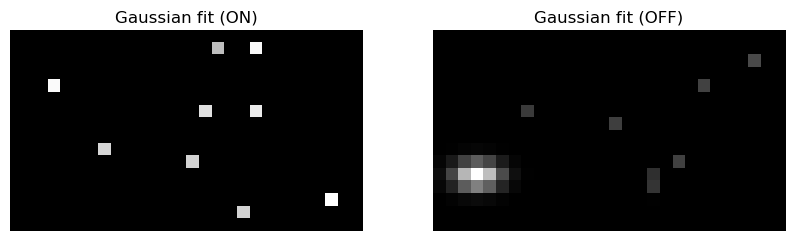

In [22]:
# Plot the Gaussian fit for ON and OFF subunits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Use grayscale: high values = white (for a bright ellipse on dark background)
ax1.imshow(gaussian_fit_on, cmap='gray')
ax1.set_title('Gaussian fit (ON)')
ax1.axis('off')
ax2.imshow(gaussian_fit_off, cmap='gray')
ax2.set_title('Gaussian fit (OFF)')
ax2.axis('off')
plt.show()

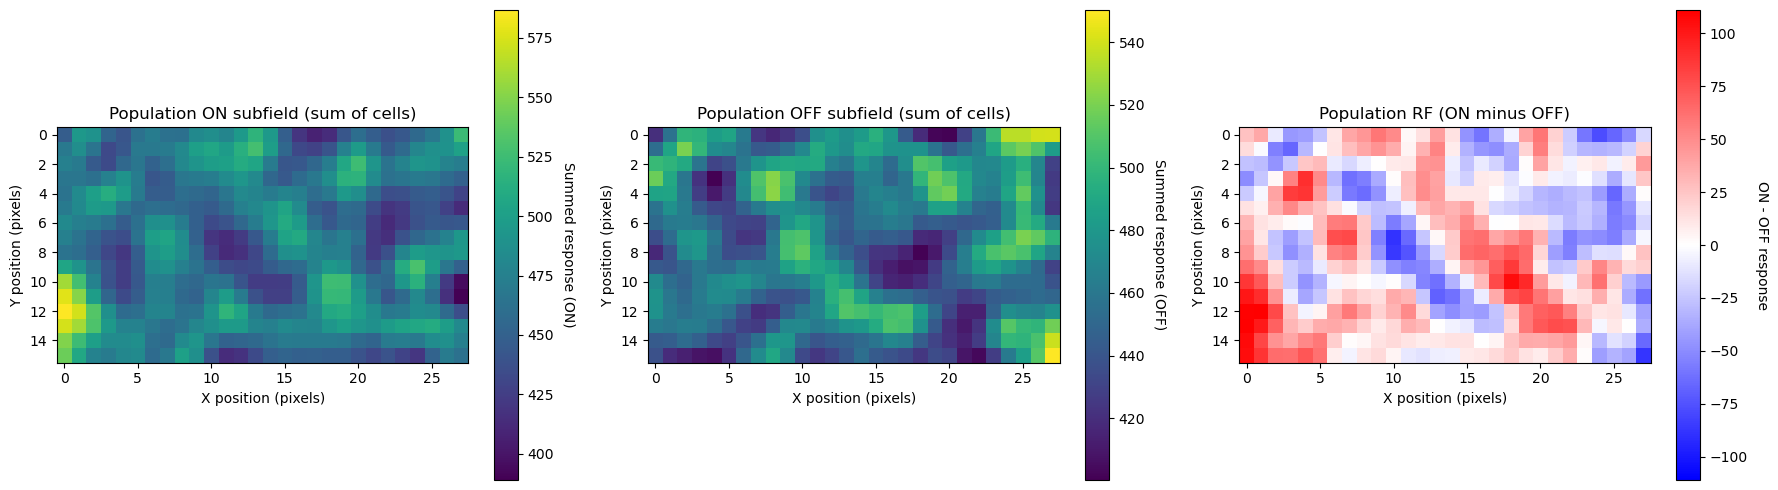

In [ ]:
# Configuration and parameters
blur_sigma = 1.0  # standard deviation for Gaussian blur (in pixel units)
save_results = False  # set to True to save output arrays to disk

# Determine stimulus frame dimensions
num_frames, height, width = stim_frames.shape

# Normalize stim_frames values: 0 → -1, 127 → 0, 255 → +1
stim_frames_norm = np.zeros_like(stim_frames, dtype=np.int8)
stim_frames_norm[stim_frames == 255] = 1
stim_frames_norm[stim_frames == 0] = -1
stim_frames_norm[stim_frames == 127] = 0

# Initialize aggregate population ON and OFF receptive field maps
pop_on = np.zeros((height, width), dtype=float)
pop_off = np.zeros((height, width), dtype=float)

def detect_events_from_spikes(spike_trace, stim_table, response_window=15):
    """
    Detect spike events that occur within a fixed window after each stimulus onset.

    Parameters:
    - spike_trace: 1D array of deconvolved spikes for one neuron.
    - stim_table: DataFrame with start and end frame indices per stimulus.
    - response_window: frames after onset to check for spikes.

    Returns:
    - List of frame indices where spike was detected within the response window.
    """
    spike_frames = []
    for row in stim_table.itertuples(index=False):
        start_idx = row[1]  # assuming [frame_index, start_idx, end_idx]
        end_idx = min(start_idx + response_window, len(spike_trace))
        spike_window = np.where(spike_trace[start_idx:end_idx] > 0)[0]
        if spike_window.size > 0:
            spike_frames.append(start_idx + spike_window[0])
    return spike_frames

spike_events_by_cell = [detect_events_from_spikes(spike_traces[i], stim_table) for i in range(spike_traces.shape[0])]

# Iterate over all neurons and accumulate their RTS (response-triggered stimulus) maps
for cell_idx, cell_spike_frames in enumerate(spike_events_by_cell):
    # Initialize this cell's ON and OFF receptive field maps
    on_map = np.zeros((height, width), dtype=float)
    off_map = np.zeros((height, width), dtype=float)
    
    # If spike_events_by_cell contains spike times (in seconds) instead of frame indices,
    # you would map each spike time to the corresponding stimulus frame here (using the stimulus table).
    # For simplicity, we assume spike_events_by_cell provides frame indices directly.
    
    # Go through each spike event (frame index) for this neuron
    for frame_idx in cell_spike_frames:
        if frame_idx < 0 or frame_idx >= num_frames:
            continue  # skip if spike frame index is out of range (safety check)
        frame_img = stim_frames_norm[frame_idx]  # stimulus image shown at that frame
        
        # Identify ON and OFF stimulus pixels in this frame
        # (Assuming white spots have value +1 and black spots -1 in frame_img)
        on_coords = np.where(frame_img > 0.5)   # positions of white spots
        off_coords = np.where(frame_img < -0.5) # positions of black spots
        
        # Mark a response for those positions (add 1 for this spike event)
        on_map[on_coords] += 1.0
        off_map[off_coords] += 1.0
    
    # Apply Gaussian spatial blurring to pool neighboring contributions
    blurred_on = gaussian_filter(on_map, sigma=blur_sigma)
    blurred_off = gaussian_filter(off_map, sigma=blur_sigma)
    
    # Accumulate this neuron's blurred maps into the population sum
    pop_on += blurred_on
    pop_off += blurred_off

# Compute the combined population receptive field as ON minus OFF
pop_combined = pop_on - pop_off

# Optionally, save the resulting arrays to disk for later use
if save_results:
    np.save("population_on_subfield.npy", pop_on)
    np.save("population_off_subfield.npy", pop_off)
    np.save("population_receptive_field_on_minus_off.npy", pop_combined)

# Visualization of the results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# 1. Population ON subfield sum
im1 = axes[0].imshow(pop_on, cmap='viridis')
axes[0].set_title("Population ON subfield (sum of cells)")
axes[0].set_xlabel("X position (pixels)")
axes[0].set_ylabel("Y position (pixels)")
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar1.set_label("Summed response (ON)", rotation=270, labelpad=15)

# 2. Population OFF subfield sum
im2 = axes[1].imshow(pop_off, cmap='viridis')
axes[1].set_title("Population OFF subfield (sum of cells)")
axes[1].set_xlabel("X position (pixels)")
axes[1].set_ylabel("Y position (pixels)")
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar2.set_label("Summed response (OFF)", rotation=270, labelpad=15)

# 3. Combined population receptive field (ON - OFF)
# Use a diverging colormap to highlight positive (ON-dominated) vs negative (OFF-dominated) regions
max_val = np.max(np.abs(pop_combined))
im3 = axes[2].imshow(pop_combined, cmap='bwr', vmin=-max_val, vmax=max_val)
axes[2].set_title("Population RF (ON minus OFF)")
axes[2].set_xlabel("X position (pixels)")
axes[2].set_ylabel("Y position (pixels)")
cbar3 = fig.colorbar(im3, ax=axes[2])
cbar3.set_label("ON - OFF response", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

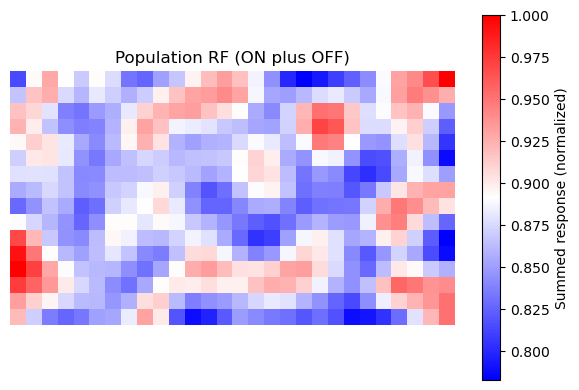

In [35]:
pop_sum = pop_on + pop_off  # <-- not ON - OFF

pop_sum_normalized = pop_sum / np.max(pop_sum)  # Scale to [0, 1]

plt.figure(figsize=(6, 4))
plt.imshow(pop_sum_normalized, cmap='bwr')
plt.axis('off')
plt.title("Population RF (ON plus OFF)")
plt.colorbar(label="Summed response (normalized)")
plt.tight_layout()
plt.show()